# Clasificacion de mortalidad Hospitalaria

Predecir la mortalidad hospitalaria de pacientes criticamente enfermos es importante debido a la creciente preocupacion sobre la perdida de control de los pacientes hacia el final de la vida. Una prediccion acertada permite tomar decisiones anticipadas para reducir la frecuencia de un proceso de muerte mecanico, doloroso y prolongado. El objetivo del examen es diseñar un clasificador que permita predecir la mortalidad de estos pacientes a partir de varias caracteristicas fisiologicas, demograficas y de severidad de la enfermedad. Para esto se busca cumplir con los siguientes objetivos:

- Obtener, visualizar y procesar los datos de acuerdo a las necesidades.

- Diseño, evaluacion y seleccion de un modelo clasificador para predecir la mortalidad hospitalaria.

- Mejora de la generalizacion de prediccion del modelo sobre los datos test.


## Visualizacion y preprocesado de los datos

Para cumplir con el proceso de obtencion y visualizacion de los datos se define la clase *Processer*. Esta clase esta encargada de descargar los datos; separar los datos de entrenamiento y prueba; identificar y almacenar los tipos de variables (Numerico o Categorico); facilitar la descripcion de las variables numericas y visualizar la proporcion en las variables categoricas y el target.

In [68]:
class Processer:
    pd = __import__("pandas")
    np = __import__("numpy")
    imb = __import__("imblearn")
    sk = __import__("sklearn")

    def __init__(self, dir, test_size = 0.2):
        self.data = self.get_data(dir)
        self.columns = self.data.columns

        self.train, self.test = self.split_train_test(test_size)
        self.types = self.get_types()

        self.cat_integers()

    def get_data(self, dir):
        raw_data = self.pd.read_csv(dir, index_col=0)
        data = raw_data.dropna()
        data = data.drop_duplicates()
        return data

    def describe(self):
        return self.data.describe()

    def count(self, data, column):
        count_ = self.train[data] if data=="y" else self.train[data][column]
        return count_.copy().value_counts()

    def shape(self, data, column):
        shape_ = self.train[data] if data=="y" else self.train[data][column]
        return shape_.copy().shape

    def get_types(self):
        get_columns = lambda type: self.train["X"].select_dtypes(include = type).columns.to_list()
        types = {"numeric":self.np.float64, "integer": self.np.int64, "categoric": "O"}

        return {name:get_columns(type) for name, type in types.items()}

    def cat_integers(self):
        for column in self.types["integer"].copy():
            if self.data[column].max()>4:
                self.types["numeric"].append(column)
            else:
                self.types["categoric"].append(column)
        self.types.pop("integer")

    def proportions(self, index = "y", column = None):
        count = self.count(index, column)
        shape = self.shape(index, column)
        count.plot(kind="pie")

        print(count/shape)

    def split_target(self):
        X = self.data.drop(["hospdead"], axis = 1)
        y = self.data["hospdead"]
        return X, y

    def split_train_test(self, test_size):
        X, y = self.split_target()
        X_train, X_test, y_train, y_test = self.sk.model_selection.train_test_split(X, y, test_size=test_size)
        return {"X": X_train, "y": y_train}, {"X": X_test, "y": y_test}

In [69]:
dir = "datos_muerte_hospitalaria.csv"
data = Processer(dir)

Notamos que ninguna variable numerica es mayor a 300 y en general la media de estos se encuentra en el punto medio entre el minimo y el maximo, con esto en mente podemos proponer un rescalamiento usando StandarScaler.

In [70]:
data.describe()

,age,num.co,scoma,avtisst,sps,aps,surv2m,surv6m,hday,diabetes,dementia,dnrday,meanbp,hrt,resp,temp,crea,sod,adlsc,hospdead
count,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000,8888.000000
mean,62.649543,1.868924,12.056818,22.623733,25.597739,37.750450,0.635254,0.519799,4.428555,0.195207,0.032853,14.758213,84.599179,97.254241,23.316044,37.104381,1.771418,137.557268,1.886694,0.260014
std,15.608807,1.346400,24.604668,13.221998,9.816206,19.791152,0.247701,0.253048,9.184803,0.396382,0.178263,20.063457,27.754427,31.560496,9.579744,1.251883,1.685958,6.053165,2.009061,0.438666
min,18.041990,0.000000,0.000000,1.000000,1.199951,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-88.000000,0.000000,0.000000,0.000000,31.699220,0.099991,110.000000,0.000000,0.000000
25%,52.766245,1.000000,0.000000,12.000000,19.097656,23.000000,0.506958,0.341980,1.000000,0.000000,0.000000,4.000000,63.000000,72.000000,18.000000,36.195310,0.899902,134.000000,0.000000,0.000000
50%,64.888455,2.000000,0.000000,19.666656,24.000000,35.000000,0.714966,0.574951,1.000000,0.000000,0.000000,9.000000,77.000000,100.000000,24.000000,36.695310,1.199951,137.000000,1.000000,0.000000
75%,74.036745,3.000000,9.000000,31.666656,30.199219,49.000000,0.825195,0.724976,4.000000,0.000000,0.000000,17.000000,107.000000,120.000000,28.000000,38.195310,1.899902,141.000000,3.000000,1.000000
max,100.849000,9.000000,100.000000,83.000000,99.187500,143.000000,0.966919,0.943970,148.000000,1.000000,1.000000,285.000000,195.000000,300.000000,90.000000,41.695310,21.500000,181.000000,7.073242,1.000000


Por otro lado, las variables categoricas no superan las 8 categorias, por lo tanto es prudente usar una codificacion One-Hot:

In [71]:
for column in data.types["categoric"]:
    print(data.count("X", column))
    print("---------------------------------")

sex
male      4028
female    3082
Name: count, dtype: int64
---------------------------------
dzgroup
ARF/MOSF w/Sepsis    2795
CHF                  1078
COPD                  745
Lung Cancer           678
MOSF w/Malig          553
Coma                  468
Cirrhosis             407
Colon Cancer          386
Name: count, dtype: int64
---------------------------------
dzclass
ARF/MOSF              3348
COPD/CHF/Cirrhosis    2230
Cancer                1064
Coma                   468
Name: count, dtype: int64
---------------------------------
race
white       5660
black       1071
hispanic     225
other         88
asian         66
Name: count, dtype: int64
---------------------------------
ca
no            4729
metastatic    1397
yes            984
Name: count, dtype: int64
---------------------------------
dnr
no dnr             4604
dnr after sadm     2316
dnr before sadm     190
Name: count, dtype: int64
---------------------------------
diabetes
0    5728
1    1382
Name: count, dtype:

Finalmente, notamos un desbalanceo de los datos con clase positiva minoritaria. Dado que se busca identificar la mortalidad hospitalaria, es importante hacer un balance de los datos para un mejor aprendizaje del modelo sobre esta clase.

hospdead
0    0.738397
1    0.261603
Name: count, dtype: float64


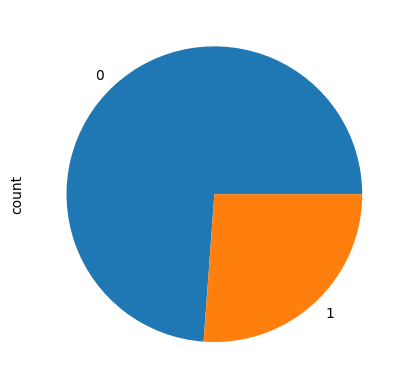

In [72]:
data.proportions()

## Clasificador

Habiendo identificado las caracteristicas de los datos y tomando en cuenta lo comentado en el procesado de estos, procedemos a definir la clase SKClassifier. Esta clase se encargara de la implementacion de un pipeline que incluye el preprocesamiento mencionado y es flexible para la seleccion del modelo de clasificacion. El preprocesamiento consta de un *ColumnTransformer* para preprocesar por separado las variables categoricas y numericas. La clase ademas toma como parametro los datos para automatizar el proceso de ajuste y evaluacion del modelo, con flexibilidad en la seleccion de la metrica de evaluacion. Finalmente, la clase permite decidir si incluir una busqueda de hiperparametros a traves de *GridSearchCV* al definir el parametro grid como *True* y sus respectivos parametros *params*:

In [73]:
class SKClassifier:
    sk = __import__("sklearn")
    imb = __import__("imblearn")
    Pipeline = __import__("imblearn").pipeline.Pipeline

    def __init__(self, data, clf, balance = None, grid = False, params = None):
        self.data = data
        self.pipeline = self.get_pipeline(clf, balance, grid, params)
        self.fit()

    def get_pipeline(self, clf, balance, grid, params):
        numeric_features = self.data.types["numeric"].copy()
        numeric_transformer = self.Pipeline(
            steps=[("scaler", self.sk.preprocessing.StandardScaler())]
        )

        categorical_features = self.data.types["categoric"].copy()
        categorical_transformer = self.Pipeline(
            steps=[
                ("encoder", self.sk.preprocessing.OneHotEncoder(handle_unknown="ignore")),
            ]
        )
        preprocessor = self.sk.compose.ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
        )

        balancers = {"over": self.imb.over_sampling.SMOTENC(categorical_features = categorical_features),
                     None: self.sk.preprocessing.FunctionTransformer()}

        steps = [
            ("balance", balancers[balance]),
            ("preprocess", preprocessor),
            ("clf", self.get_grid(clf, grid, params))]
        pipeline = self.Pipeline(steps)
        return pipeline

    def get_grid(self, clf, grid, params):
        clf = clf if not grid else self.sk.model_selection.GridSearchCV(clf, param_grid = params, n_jobs=-1, refit=True)
        return clf

    def fit(self):
        train = self.data.train.copy()
        self.pipeline.fit(train["X"], train["y"])

    def predict(self, X):
        return self.pipeline.predict(X)

    def evaluate(self, metric):
        X, y = self.data.test.copy().values()
        metric = getattr(self.sk.metrics, metric)
        y_pred = self.predict(X)
        return metric(y, y_pred)

A partir de esto podemos hacer una exploracion de modelos con los valores predeterminados de cada clasificador, para identificar el de mayor desempeño. En este caso comparamos una regresion logistica, un arbol de decision, el metodo de clasificacion por vectores de soporte, una clasificacion por k-neighbours y un perceptron multicapa. Se evaluaran los modelos bajo las metricas de precision, recall, accuracy y f1, dado que es un problema de clasificacion binaria y estas permiten evaluar de manera optima el desempeño del clasificador.

In [74]:
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier

names = []
precision = []
recall = []
acc = []
f1 = []

classifier = {"Logistic": LogisticRegression(),
       "Desicion Tree": DecisionTreeClassifier(),
       "Support vector": SVC(),
       "K-Neighbors": KNeighborsClassifier(),
       "Perceptron": MLPClassifier(),
       "XGBoost": XGBClassifier()}

for name, clf in classifier.items():
    model = SKClassifier(data, clf)
    names.append(name)
    precision.append(model.evaluate("precision_score"))
    recall.append(model.evaluate("recall_score"))
    acc.append(model.evaluate("accuracy_score"))
    f1.append(model.evaluate("f1_score"))

DataFrame({"Precision":precision, "Recall": recall, "Accuracy": acc, "F1": f1}, index = names)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Precision,Recall,Accuracy,F1
Logistic,0.824873,0.720621,0.890326,0.769231
Desicion Tree,0.709821,0.705100,0.852081,0.707453
Support vector,0.833333,0.720621,0.892576,0.772889
K-Neighbors,0.810496,0.616408,0.866142,0.700252
Perceptron,0.765101,0.758315,0.879640,0.761693
XGBoost,0.811594,0.745011,0.891451,0.776879


In [75]:
dir = "datos_muerte_hospitalaria.csv"
data = Processer(dir)

names = []
precision = []
recall = []
acc = []
f1 = []

classifier = {"Logistic": LogisticRegression(),
       "Desicion Tree": DecisionTreeClassifier(),
       "Support vector": SVC(),
       "K-Neighbors": KNeighborsClassifier(),
       "Perceptron": MLPClassifier(),
       "XGBoost": XGBClassifier()}

for name, clf in classifier.items():
    model = SKClassifier(data, clf, balance = "over")
    names.append(name)
    precision.append(model.evaluate("precision_score"))
    recall.append(model.evaluate("recall_score"))
    acc.append(model.evaluate("accuracy_score"))
    f1.append(model.evaluate("f1_score"))

DataFrame({"Precision":precision, "Recall": recall, "Accuracy": acc, "F1": f1}, index = names)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Precision,Recall,Accuracy,F1
Logistic,0.724203,0.848352,0.878515,0.781377
Desicion Tree,0.680769,0.778022,0.849831,0.726154
Support vector,0.764471,0.841758,0.893138,0.801255
K-Neighbors,0.662116,0.852747,0.850956,0.745437
Perceptron,0.746479,0.815385,0.881890,0.779412
XGBoost,0.795309,0.819780,0.899888,0.807359


Notamos que el modelo base de vectores de soporte, seguido por la regresion logisitica, presenta los mejores desempeños para cada una de las metricas establecidas. A partir de esto, el objetivo es hacer una seleccion de modelo variando los hiperparametros del modelo de vectores de soporte. Ademas, notamos como el oversampling reduce la precision, el accuracy y el F1 de los modelos pero mejora en gran medida el recall, lo cual es de suma importancia debido a que es mas critico para el paciente si se marca erronamente como no mortalidad hosptalaria (falso negativo) que como positivo cuando no es (falso positivo). Con esto en mente podemos ademas estudiar el entrenamiento del modelo aplicando pesos sobre las clases:

In [55]:
params = {"C":[0.1, 1, 10, 100],
          "kernel": ["linear", "poly", "rbf"],
          "class_weight" : [None, "balanced"]}

best_svc = SKClassifier(data, SVC(), grid = True, params = params)
best_svc.evaluate("f1_score")

0.8247191011235955

In [58]:
best_svc.pipeline.get_params()

{'memory': None,
 'steps': [('balance', FunctionTransformer()),
  ('preprocess',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['age', 'scoma', 'avtisst', 'sps', 'aps',
                                     'surv2m', 'surv6m', 'dnrday', 'meanbp', 'hrt',
                                     'resp', 'temp', 'crea', 'sod', 'adlsc',
                                     'num.co', 'hday']),
                                   ('cat',
                                    Pipeline(steps=[('encoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['sex', 'dzgroup', 'dzclass', 'race', 'ca',
                                     'dnr', 'diabetes', 'dementia'])])),
  ('clf',
   GridSearchCV(estimator=SVC(), n_jobs=-1,
                param_grid={'C': [0.1, 1, 10, 100],
                            'class

In [77]:
DataFrame({"Precision":best_svc.evaluate("precision_score"), "Recall": best_svc.evaluate("recall_score"), "Accuracy": best_svc.evaluate("accuracy_score"), "F1": best_svc.evaluate("f1_score")}, index = ["Best SVC"])

,Precision,Recall,Accuracy,F1
Best SVC,0.859485,0.792657,0.912261,0.824719


In [78]:
params = {"n_estimators": [10, 100],
          "max_depth": [5, 50],
         "learning_rate": [0.1, 1, 10],
         "reg_lambda": [1, 10, 100]}

best_xgb = SKClassifier(data, XGBClassifier(), grid = True, params = params)
best_xgb.pipeline.get_params()

{'memory': None,
 'steps': [('balance', FunctionTransformer()),
  ('preprocess',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['age', 'scoma', 'avtisst', 'sps', 'aps',
                                     'surv2m', 'surv6m', 'dnrday', 'meanbp', 'hrt',
                                     'resp', 'temp', 'crea', 'sod', 'adlsc',
                                     'num.co', 'hday']),
                                   ('cat',
                                    Pipeline(steps=[('encoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['sex', 'dzgroup', 'dzclass', 'race', 'ca',
                                     'dnr', 'diabetes', 'dementia'])])),
  ('clf',
   GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, col

In [80]:
DataFrame({"Precision":best_xgb.evaluate("precision_score"), "Recall": best_xgb.evaluate("recall_score"), "Accuracy": best_xgb.evaluate("accuracy_score"), "F1": best_xgb.evaluate("f1_score")}, index = ["Best XGBoost"])

,Precision,Recall,Accuracy,F1
Best XGBoost,0.849885,0.808791,0.914511,0.828829


### Tensorflow

Por ultimo, es prudente comparar el desempeño de este modelo contra una red neuronal profunda, comparando si es necesario adentrarse en el deep learning para mejorar el desempeño del clasificador. Para esto se define la clase *TFClassifier* que hace uso de TensorFlow para definir una red neuronal a partir del parametro de capas (layers), tomando la funcion de activacion sigmoide dado que es una clasificacion binaria. Se hara optimizacion por ADAM de la funcion de perdida entropia cruzada binaria. Ademas, la clase incluye una funcion de preprocesado de datos que ejecuta los mismos pasos que en el modelo de sklearn sin balanceo de clases.

In [66]:
class TFClassifier:
    tf = __import__("tensorflow")
    matplotlib = __import__("matplotlib")
    sk = __import__("sklearn")
    from sklearn.pipeline import Pipeline

    def __init__(self, data, layers, epochs = 200):
        self.data = data
        self.preprocess()
        print(self.data.train["X"])

        optimizer = self.tf.keras.optimizers.Adam()
        self.network = self.tf.keras.Sequential()
        self.add(layers)
        self.network.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = [self.tf.keras.metrics.BinaryAccuracy()])
        self.history = None
        self.fit(epochs)

    def preprocess(self):
        numeric_features = self.data.types["numeric"].copy()
        numeric_transformer = self.Pipeline(
            steps=[("scaler", self.sk.preprocessing.StandardScaler())]
        )

        categorical_features = self.data.types["categoric"].copy()
        categorical_transformer = self.Pipeline(
            steps=[
                ("encoder", self.sk.preprocessing.OneHotEncoder(handle_unknown="ignore")),
            ]
        )
        preprocessor = self.sk.compose.ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
        )
        self.data.train["X"] = preprocessor.fit_transform(self.data.train["X"])

    def get_network(self, layers):
        for layer in layers:
            self.add(*layer)

    def add(self, n, input = False):
        input = (len(self.data.columns.values),) if input else None
        layer = self.tf.keras.layers.Dense(n, kernel_initializer='uniform', activation = 'sigmoid', input_shape = input)
        self.network.add(layer)

    def fit(self, epochs):
        train = self.data.train.copy()
        X = train["X"].copy()
        y = train["y"].copy()
        self.history = self.network.fit(X, y, epochs = epochs)

    def predict(self, X):
        self.network.predict(X)

    def plot(self):
        plt = self.matplotlib.pyplot
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0, 0].plot(self.history.history['loss'])
        ax[0, 0].set_title('Curva de error')
        ax[0, 0].set(xlabel='Error')

        ax[0, 1].plot(self.history.history['binary_accuracy'])
        ax[0, 1].set_title('Curva del accuracy')
        ax[0, 1].set(xlabel='Accuracy')

        fig.supxlabel('Epoca')

In [67]:
dir = "datos_muerte_hospitalaria.csv"
data = Processer(dir)

layers = [(27, True),
          (10),
          (5),
          (1)]

mlp = TFClassifier(data, layers)
mlp.plot()

[[-0.05517336  1.03650622  2.00958753 ...  1.          1.
   0.        ]
 [ 0.62081896  1.32503816 -1.03755795 ...  0.          1.
   0.        ]
 [-0.3269939  -0.48859119 -0.17420047 ...  0.          1.
   0.        ]
 ...
 [-1.09190842  3.6332937   0.33365752 ...  1.          1.
   0.        ]
 [ 0.46520832 -0.48859119 -1.64698704 ...  0.          1.
   0.        ]
 [ 0.314724   -0.48859119  2.23812345 ...  0.          1.
   0.        ]]
Epoch 1/200


ValueError: Invalid dtype: TrackedList

## Conclusiones

Del presente proyecto concluimos que el para esta caso de estudio la clasificacion con xgboost, seguido de vectores de soporte, presenta el mejor desempeño, alcanzando un alto para los scores relevantes. A pesar de ser cercanos, el modelo xgboost se desenvolvio mejor en el aprendizaje de la clase positiva en el sobremuestreo. Ademas, el sobremuestreo es una herramienta importante para mejorar el desempeño de acuerdo a los objetivos propuestos, donde se busca una mejora en el recall del modelo.

Proyecto realizado por: Juan Andres Guzman Pineda